In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

from keras import backend as K
K.set_image_dim_ordering('th')

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

/Users/sukilau/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
def mylistdir(directory):
    """A specialized version of os.listdir() that ignores files that start with a leading period."""
    filelist = os.listdir(directory)
    return [x for x in filelist
            if not (x.startswith('.'))]

In [3]:
# Load data

PATH = os.getcwd()
data_path = PATH + '/data'
data_dir_list = mylistdir((data_path))

img_rows=128
img_cols=128
num_channel=1
num_epoch=5

num_classes = 2
img_data_list=[]

for dataset in data_dir_list:
    img_list=mylistdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset - '+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img,0)
        input_img_resize=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img_resize)

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print('Shape of imgage data ', img_data.shape, '{}\n')

if num_channel==1:
    if K.image_dim_ordering()=='th':
        img_data= np.expand_dims(img_data, axis=1) 
        print('Shape of imgage data ', img_data.shape, '\n')
    else:
        img_data= np.expand_dims(img_data, axis=4) 
        print('Shape of imgage data ', img_data.shape, '\n')

else:
    if K.image_dim_ordering()=='th':
        img_data=np.rollaxis(img_data,3,1)
        print('Shape of imgage data ', img_data.shape, '\n')

Loaded the images of dataset - dali

Loaded the images of dataset - vangogh

Shape of imgage data  (160, 128, 128) {}

Shape of imgage data  (160, 1, 128, 128) 



In [4]:
# Preprocess data and split into training and test set

num_classes = 2
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')
labels[0:80]=0
labels[81:160]=1
names = ['dali','vangogh']

Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,Y, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [5]:
# Define the model

input_shape=img_data[0].shape

model = Sequential()

model.add(Convolution2D(32, 3,3,border_mode='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])


# Train the model

hist = model.fit(X_train, y_train, batch_size=16, nb_epoch=num_epoch, verbose=1, validation_data=(X_test, y_test))

/Users/sukilau/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(1, 128, 1..., padding="same")`
/Users/sukilau/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
/Users/sukilau/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/Users/sukilau/anaconda/lib/python3.6/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 128 samples, validate on 32 samples
Epoch 1/5
128/128 [==============================] - 31s - loss: 1.3146 - acc: 0.4766 - val_loss: 0.6923 - val_acc: 0.5938
Epoch 2/5
128/128 [==============================] - 33s - loss: 0.6822 - acc: 0.5859 - val_loss: 0.7078 - val_acc: 0.5000

Test Loss: 0.663442254066
Test accuracy: 0.71875


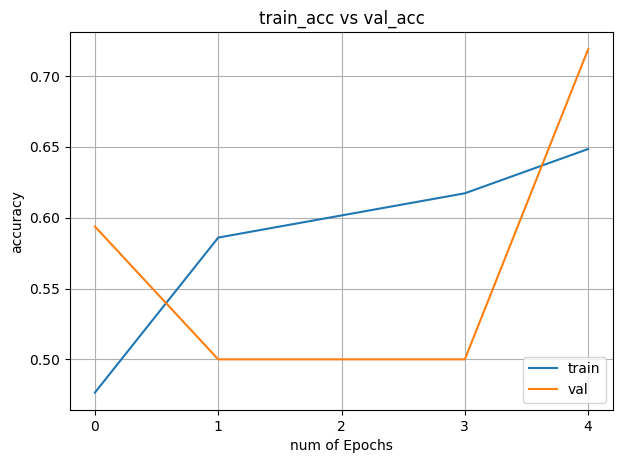

In [6]:
# Evaluate the model

score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc = range(num_epoch)

fig = plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

plt.show()
fig.savefig('plot.jpg')

In [7]:
# Make prediction

test_image = cv2.imread('data/vangogh/ActiOn_95.jpg', 0)
test_image=cv2.resize(test_image,(128,128))
test_image = np.array(test_image)
test_image = test_image.astype('float32')
test_image /= 255
print (test_image.shape)
   
if num_channel==1:
    if K.image_dim_ordering()=='th':
        test_image= np.expand_dims(test_image, axis=0)
        test_image= np.expand_dims(test_image, axis=0)
        print (test_image.shape)
    else:
        test_image= np.expand_dims(test_image, axis=3) 
        test_image= np.expand_dims(test_image, axis=0)
        print (test_image.shape)

else:
    if K.image_dim_ordering()=='th':
        test_image=np.rollaxis(test_image,2,0)
        test_image= np.expand_dims(test_image, axis=0)
        print (test_image.shape)
    else:
        test_image= np.expand_dims(test_image, axis=0)
        print (test_image.shape)

print((model.predict(test_image)))
print(model.predict_classes(test_image))

(128, 128)
(1, 1, 128, 128)
[[ 0.48610416  0.51389581]]
1/1 [==============================] - 0s
[1]


(1, 1, 32, 126, 126)
(32, 126, 126)
(126, 126, 32)


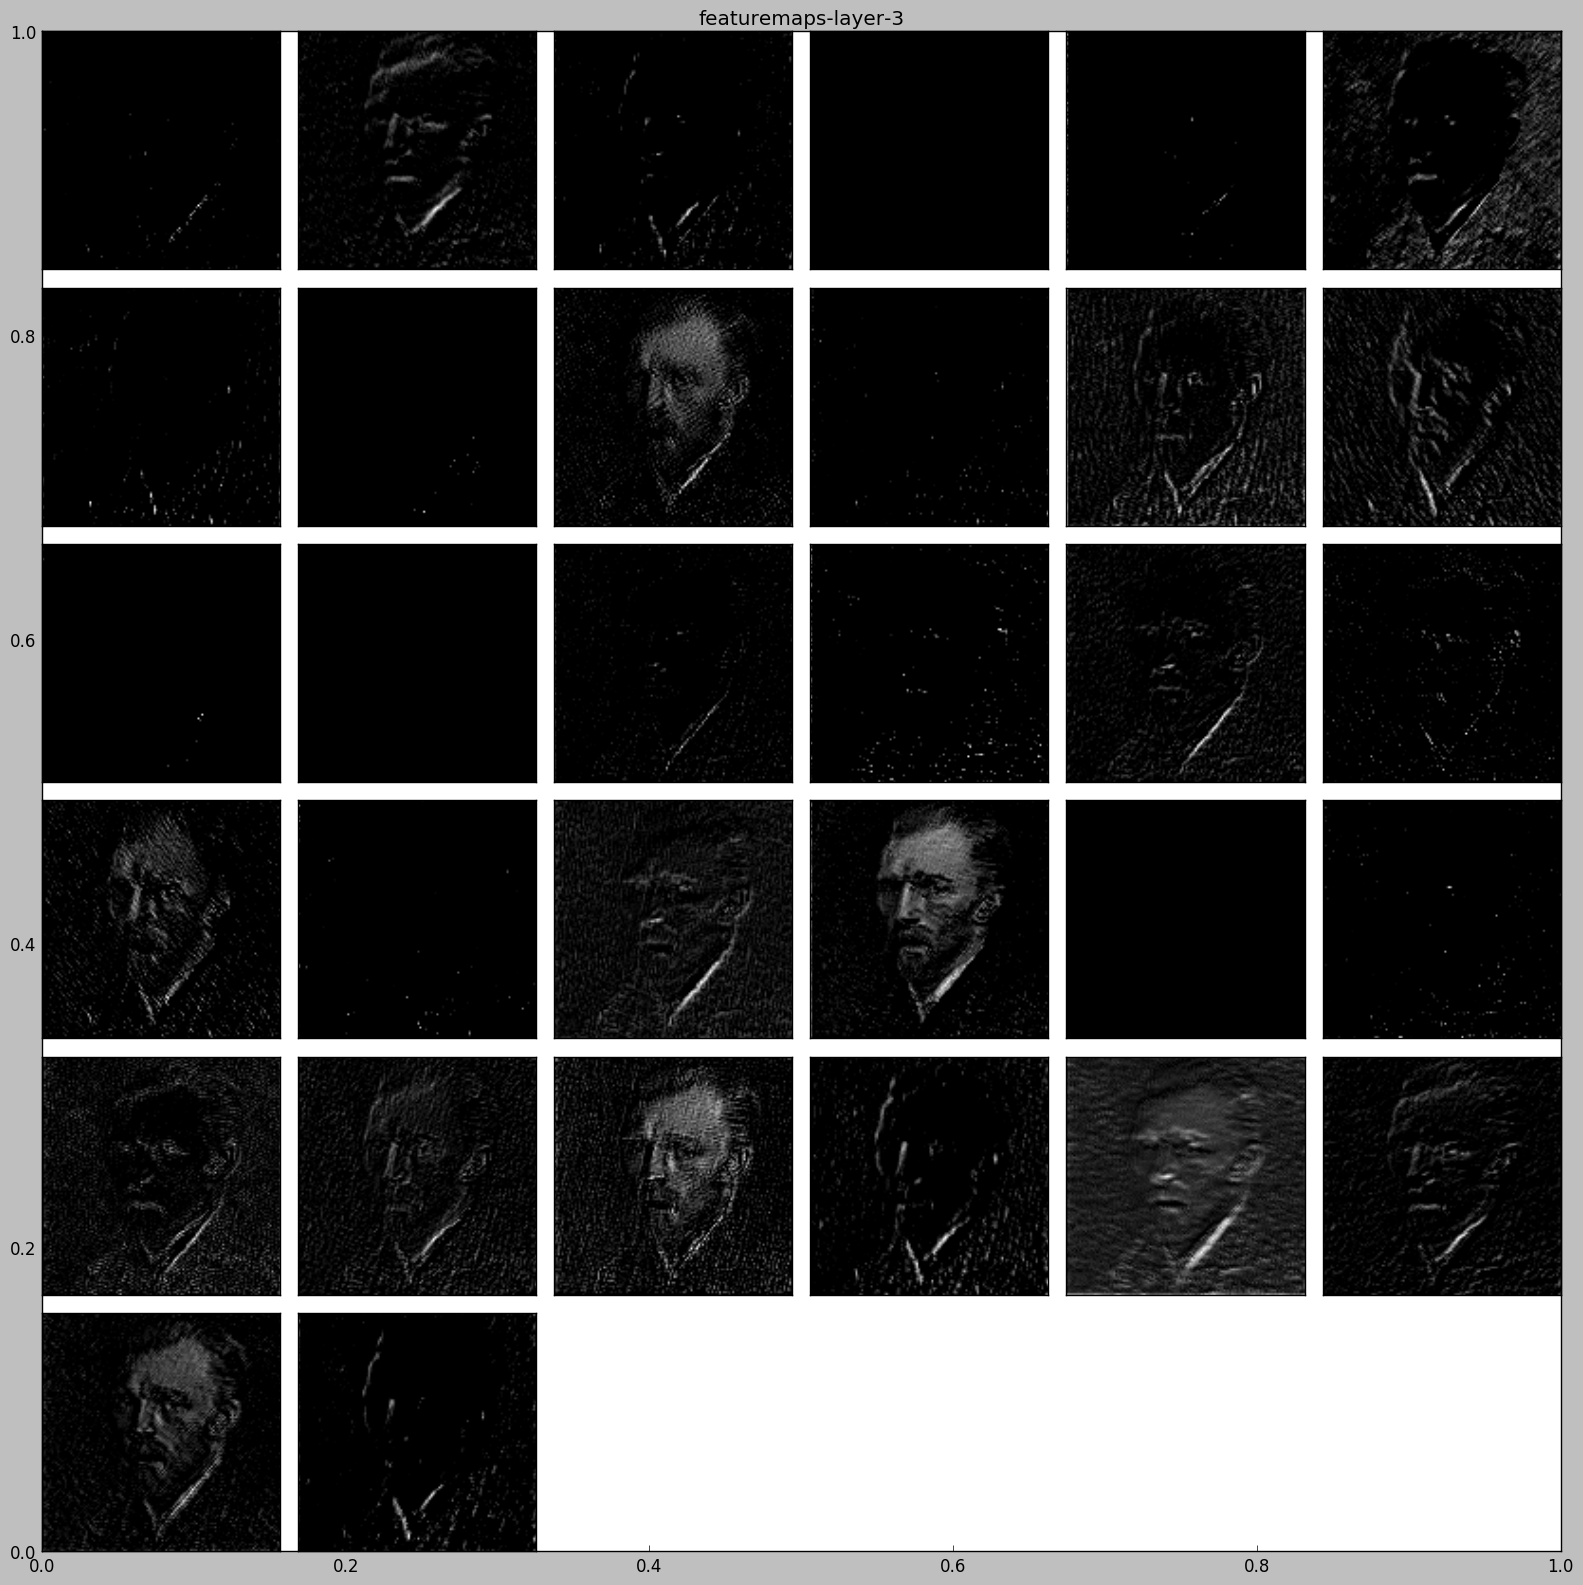

In [8]:
# Visualize intermediate layer

def get_featuremaps(model, layer_idx, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

layer_num=3
filter_num=0

activations = get_featuremaps(model, int(layer_num),test_image)

print (np.shape(activations))
feature_maps = activations[0][0]      
print (np.shape(feature_maps))

if K.image_dim_ordering()=='th':
    feature_maps=np.rollaxis((np.rollaxis(feature_maps,2,0)),2,0)
print (feature_maps.shape)

num_of_featuremaps=feature_maps.shape[2]
fig = plt.figure(figsize=(16,16))
plt.title("featuremaps-layer-{}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
for i in range(int(num_of_featuremaps)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
    ax.imshow(feature_maps[:,:,i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
plt.show()
fig.savefig("featuremaps-layer-{}".format(layer_num) + '.jpg')